In [25]:
import numpy as np
import pandas as pd

In [26]:
ls

autoencoder.ipynb          eda.ipynb
autoencoder_starter.ipynb  eda_2.ipynb
crop.ipynb                 explore_brain_data.ipynb
data.mat                   train_basic_model.ipynb


In [27]:
# load in mat_files/1/sub_01_run_01.mat
import scipy.io
mat = scipy.io.loadmat('../mat_files/1/sub_01_run_01.mat')
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'new_brain'])


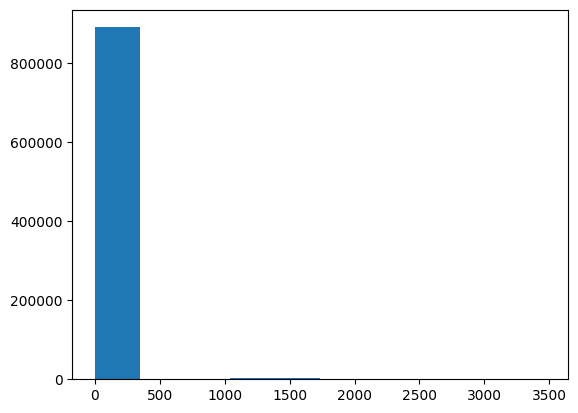

In [28]:
import matplotlib.pyplot as plt

# show the distribution of values in new_brain
plt.hist(mat['new_brain'].flatten())
plt.show()


In [29]:
# describe the distribution of values in new_brain
# use pandas
df = pd.DataFrame(mat['new_brain'].flatten())
print(df.describe())

                   0
count  902629.000000
mean       17.910767
std       162.852396
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3473.316113


In [30]:
import torch

brain = torch.tensor(mat['new_brain'])  # Keep original shape
brain = torch.log1p(brain)  # log1p safely handles small values by computing log(1 + x)

In [31]:
brain.shape

torch.Size([91, 109, 91])

In [32]:
brain

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [33]:
# now describe the distribution of values in brain
df = pd.DataFrame(brain.flatten())
print(df.describe())


                   0
count  902629.000000
mean        0.092089
std         0.810301
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.153153


In [34]:
import json
import os
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Load both mapping files
with open("mappings/level1_mapping.json", "r") as f:
    activity_labels = json.load(f)

with open("mappings/stim_file_mapping.json", "r") as f:
    folder_mapping = json.load(f)

# Create folder to activity mapping
folder_to_activity = {str(v): k for k, v in folder_mapping.items()}

def get_label_for_file(file_path):
    # Extract folder number from path
    folder_num = str(Path(file_path).parent.name)
    
    activity_name = folder_to_activity.get(folder_num)
    if activity_name is None:
        print(f"Warning: No activity mapping found for folder {folder_num} (file: {file_path})")
        return None
        
    label = activity_labels.get(activity_name)
    if label is None:
        print(f"Warning: No label found for activity {activity_name} (folder: {folder_num})")
        return None
        
    return 1 if label == "S" else 0

# Create labels array
labels = []

print("Creating labels...")
for brain_path in tqdm(brain_paths):
    label = get_label_for_file(brain_path)
    if label is not None:
        labels.append(label)

labels = np.array(labels)
print(f"\nTotal labels created: {len(labels)}")
print(f"Label distribution: {np.bincount(labels)}")

# Verify some examples
print("\nExample mappings:")
for brain_path in brain_paths[:5]:
    folder_num = Path(brain_path).parent.name
    label = get_label_for_file(brain_path)
    activity = folder_to_activity.get(folder_num)
    print(f"File: {brain_path}")
    print(f"Folder: {folder_num}")
    print(f"Activity: {activity}")
    print(f"Label: {label}")
    print("-" * 50)

FileNotFoundError: [Errno 2] No such file or directory: 'mappings/level1_mapping.json'

In [ ]:
# do this for all mat files in mat_files/*
import glob
import os

# we then want to write a h5 file with the brains and labels
import h5py

files = glob.glob('../mat_files/*/*.mat')
brains = []
labels = []
for file in files:
    mat = scipy.io.loadmat(file)
    brain = torch.tensor(mat['new_brain'])
    brains.append(brain)
    labels.append(get_label_for_folder(file))

# write to h5 file
with h5py.File('brain_data_full.h5', 'w') as f:
    f.create_dataset('brains', data=brains)
    f.create_dataset('labels', data=labels)
